### Importing the libraries

In [1]:
import sys
import os

# Get the absolute path of the src directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from utils.modelling_utils import OneHotFeatureEncoder, FeatureEngineer, OrdinalFeatureEncoder, TargetFeatureEncoder, ColumnDropper, StandardFeatureScaler, RecursiveFeatureEliminator
from utils.modelling_utils import plot_classification_kfold_cv, classification_kfold_cv, evaluate_classifier

c:\Users\speed\OneDrive\Documents\BITS_Pilani_Mtech\Sem2\DMML\Assignment\Assignment_1\assign1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
### Visualization Settings
%matplotlib inline

#mpl.style.use('ggplot') 

mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['grid.color']          = 'lightgray'
#mpl.rcParams['figure.dpi']          = 150
mpl.rcParams['axes.grid']           = True
mpl.rcParams['font.size']           = 12

# Palette Setting
color_palette = ['#023047', '#e85d04', '#0077b6', '#ff8200', '#0096c7', '#ff9c33']
# Setting as the palette
sns.set_palette(sns.color_palette(color_palette))
# Display
sns.color_palette(color_palette)

[(0.00784313725490196, 0.18823529411764706, 0.2784313725490196),
 (0.9098039215686274, 0.36470588235294116, 0.01568627450980392),
 (0.0, 0.4666666666666667, 0.7137254901960784),
 (1.0, 0.5098039215686274, 0.0),
 (0.0, 0.5882352941176471, 0.7803921568627451),
 (1.0, 0.611764705882353, 0.2)]

### Read the dataset

In [4]:
data_path = '../../data/input/BankChurners.csv'
df = pd.read_csv(data_path)
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [5]:
df.columns = [x.lower() for x in df.columns]
df.rename(columns={'attrition_flag': 'churn_flag'}, inplace=True)
df['churn_flag'] = df['churn_flag'].map({'Attrited Customer': 1, 'Existing Customer': 0})

### Split Data into Train and Test sets
- Split Data into Train and Test sets.
- Perform EDA on training set to avoid data leakage, and evaluate model with unseen data
- Perform Startified Split for Train and Test sets to maintain same percentage of target class

In [6]:
X = df.drop(columns=['churn_flag'])
y = df['churn_flag'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (8101, 22).
Train target dataset shape: (8101,).
Test predictor dataset shape: (2026, 22).
Test target dataset shape: (2026,).


In [8]:
print(f'Train target proportion: ')
print(f'{y_train.value_counts(normalize=True)}')
print(f'\nTest target proportion: ')
print(f'{y_test.value_counts(normalize=True)}')

Train target proportion: 
churn_flag
0    0.839279
1    0.160721
Name: proportion, dtype: float64

Test target proportion: 
churn_flag
0    0.839585
1    0.160415
Name: proportion, dtype: float64


# 5. Feature engineering, data cleaning and preprocessing

Feature Engineering

- Ratio features: 
    -   products_per_dependent (total_relationship_count/dependent_count)
    -   trans_amt_per_dependent (total_trans_amt/dependent_count)
    -   trans_ct_per_dependent (total_trans_ct/dependent_count) 
    -   trans_amt_per_products (total_trans_amt/total_relationship_count)
    -   trans_ct_per_products (total_trans_ct/total_relationship_count)
    -   avg_trans_amt (total_trans_amt/total_trans_ct)
    -   credit_util_rate (total_revolving_bal/credit_limit)
    -   proportion_inactive_months (months_inactive_12_mon/months_on_book)
    -   products_per_tenure (total_relationship_count/months_on_book)
    -   products_per_contacts (total_relationship_count/contacts_count_12_mon)
    -   dependents_per_contacts (dependent_count/contacts_count_12_mon)
    -   trans_ct_per_contacts (total_trans_ct/contacts_count_12_mon)
    -   products_per_inactivity (total_relationship_count/months_inactive_12_mon)
    -   dependents_per_inactivity (dependent_count/months_inactive_12_mon)
    -   trans_ct_per_inactivity (total_trans_ct/months_inactive_12_mon)
    -   trans_amt_per_credit_limit (total_trans_amt/credit_limit)
    -   age_per_tenure (customer_age/months_on_book)
    -   trans_ct_per_tenure (total_trans_ct/months_on_book)
    -   trans_amt_per_tenure (total_trans_amt/months_on_book)
- Sum features: 
    -   total_spending (total_trans_amt + total_revolving_bal)
    -   education_income_levels (education_level + income_category, ordinal)
    -   inactivity_contacts (contacts_count_12_mon + months_inactive_12_mon)
- Considering these are numeric variables, all will be scaled to go for the stratified k-fold cross validation (models comparison) step.
- Eventually, other features will be added. These features above can already capture hided relationships and patterns. Moreover, they make sense in the business context. This is something to take into account when performing feature engineering.

Check numerical features.

In [9]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features.')
print('They are:')
print(numerical_features)

There are 17 numerical features.
They are:
['clientnum', 'customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2']


Check categorical features cardinality and unique values.

In [10]:
categorical_features = X_train.select_dtypes('object').columns.to_list()
print(f'There are {len(categorical_features)} categorical features.')
print('They are: ')
print(categorical_features)

There are 5 categorical features.
They are: 
['gender', 'education_level', 'marital_status', 'income_category', 'card_category']


In [11]:
for feature in categorical_features:
    print(feature)
    print('-'*40)
    print(f'There are {X_train[feature].nunique()} unique values. They are: ')
    print(X_train[feature].value_counts(normalize=True))
    print()

gender
----------------------------------------
There are 2 unique values. They are: 
gender
F    0.527342
M    0.472658
Name: proportion, dtype: float64

education_level
----------------------------------------
There are 7 unique values. They are: 
education_level
Graduate         0.306382
High School      0.203679
Unknown          0.148994
Uneducated       0.146031
College          0.098259
Post-Graduate    0.052710
Doctorate        0.043945
Name: proportion, dtype: float64

marital_status
----------------------------------------
There are 4 unique values. They are: 
marital_status
Married     0.463523
Single      0.387853
Unknown     0.074682
Divorced    0.073941
Name: proportion, dtype: float64

income_category
----------------------------------------
There are 6 unique values. They are: 
income_category
Less than $40K    0.349586
$40K - $60K       0.178990
$80K - $120K      0.149241
$60K - $80K       0.140230
Unknown           0.109369
$120K +           0.072584
Name: proportion, 

In [12]:
# Construct the preprocessor for linear models.
one_hot_encoding_features = ['gender', 
                             'education_level', 
                             'marital_status', 
                             'income_category', 
                             'card_category']
std_scaling_features = ['customer_age', 
                        'dependent_count', 
                        'months_on_book', 
                        'total_relationship_count', 
                        'months_inactive_12_mon', 
                        'contacts_count_12_mon', 
                        'credit_limit', 
                        'total_revolving_bal', 
                        'avg_open_to_buy', 
                        'total_amt_chng_q4_q1', 
                        'total_trans_amt', 
                        'total_trans_ct', 
                        'total_ct_chng_q4_q1',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'products_per_dependent',
                        'trans_amt_per_dependent',
                        'trans_ct_per_dependent',
                        'trans_amt_per_products',
                        'trans_ct_per_products',
                        'avg_trans_amt',
                        'credit_util_rate',
                        'proportion_inactive_months',
                        'products_per_tenure',
                        'products_per_contacts',
                        'dependents_per_contacts',
                        'trans_ct_per_contacts',
                        'products_per_inactivity',
                        'dependents_per_inactivity',
                        'trans_ct_per_inactivity',
                        'trans_amt_per_credit_limit',
                        'age_per_tenure',
                        'trans_ct_per_tenure',
                        'trans_amt_per_tenure',
                        'total_spending',
                        'inactivity_contacts',
                        'education_income_levels']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

linear_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('std_scaler', StandardFeatureScaler(to_scale=std_scaling_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_preprocessed_linear = linear_preprocessor.fit_transform(X_train)
X_train_preprocessed_linear.shape

(8101, 55)

In [13]:
# Construct the preprocessor for tree-based models.
one_hot_encoding_features = ['gender']

# I will encode 'unknown' as the last one, due to its churn rate (among the first or second highest one).
ordinal_encoding_orders = {
    'education_level': ['Uneducated',
                        'High School',
                        'College',
                        'Graduate',
                        'Post-Graduate',
                        'Doctorate',
                        'Unknown'],
    'income_category': ['Less than $40K',
                        '$40K - $60K',
                        '$60K - $80K',
                        '$80K - $120K',
                        '$120K +',
                        'Unknown'],
    'card_category': ['Blue',
                      'Silver',
                      'Gold',
                      'Platinum']
}

target_encoding_features = ['marital_status']

to_drop_features = ['naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1', 
                    'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2',
                    'clientnum',
                    'avg_open_to_buy']

tree_preprocessor = Pipeline(
    steps=[
        ('feature_engineer', FeatureEngineer()),
        ('one_hot_encoder', OneHotFeatureEncoder(to_encode=one_hot_encoding_features)),
        ('ordinal_encoder', OrdinalFeatureEncoder(to_encode=ordinal_encoding_orders)),
        ('target_encoder', TargetFeatureEncoder(to_encode=target_encoding_features)),
        ('col_dropper', ColumnDropper(to_drop=to_drop_features))
    ]
)

X_train_preprocessed_tree = tree_preprocessor.fit_transform(X_train, y_train)
X_train_preprocessed_tree.shape

(8101, 40)

# 6. Model training, comparison, selection and tuning

In [14]:
# Define linear and tree-based models dictionaries for k-fold cross validation.
linear_models = {
                'Logistic Regression': LogisticRegression(),
                'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }

tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

Logistic Regression results: 
--------------------------------------------------
Training score: 0.8148340125919845
Average validation score: 0.9428015959558291
Standard deviation: 0.005196293958667355
Training time: 0.05253 seconds

Linear SVC results: 
--------------------------------------------------
Training score: 0.813085540048471
Average validation score: 0.9423902368133715
Standard deviation: 0.005037047313217295
Training time: 0.04197 seconds

KNN results: 
--------------------------------------------------
Training score: 0.8708612159238202
Average validation score: 0.9289137881952014
Standard deviation: 0.01102718807675875
Training time: 0.00452 seconds



,model,avg_val_score,train_score
0,Logistic Regression,0.942802,0.814834
1,Linear SVC,0.942390,0.813086
2,KNN,0.928914,0.870861


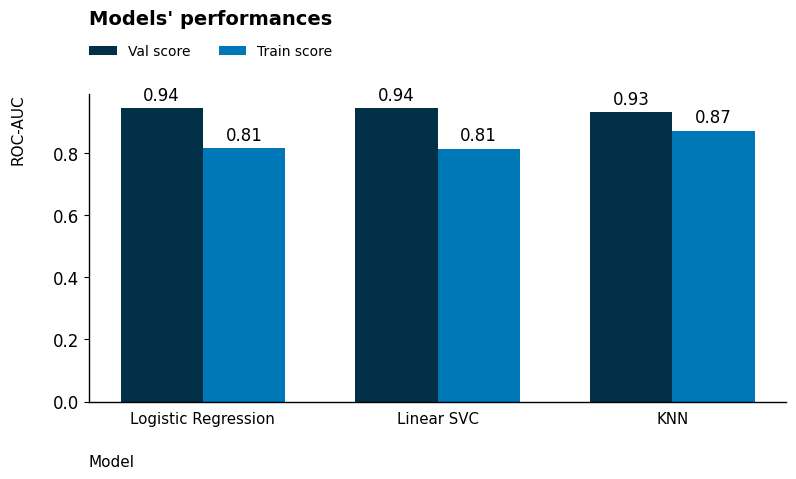

In [15]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train_preprocessed_linear, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.8747970454306173
Standard deviation: 0.008913713762309558
Training time: 0.15094 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.98755222352573
Standard deviation: 0.0025871985043503633
Training time: 1.55284 seconds

[LightGBM] [Info] Number of positive: 1302, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5536
[LightGBM] [Info] Number of data points in the train set: 8101, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160721 -> initscore=-1.652874
[LightGBM] [Info] Start training from score -1.652874
[LightGBM] [Info] Nu

,model,avg_val_score,train_score
0,LightGBM,0.992292,1.0
1,Random Forest,0.987552,1.0
2,Decision Tree,0.874797,1.0


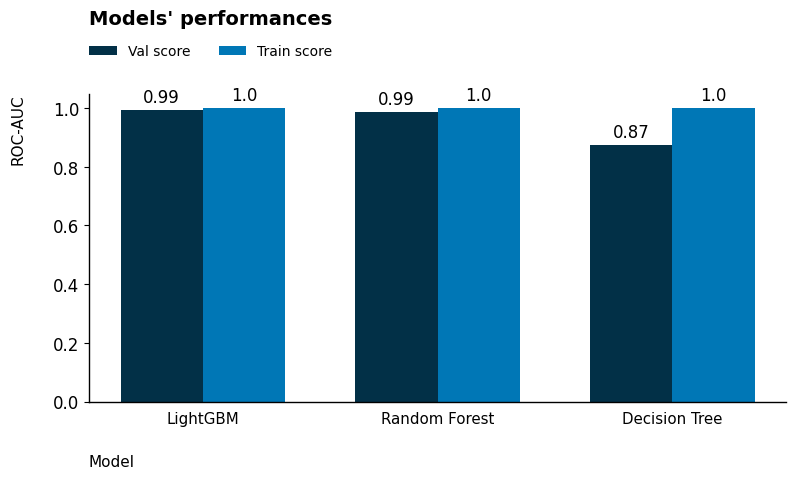

In [16]:
# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train_preprocessed_tree, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

### Feature selection

In [17]:
# Recursively select the features with highest feature importances until the final desired number of features is obtained.
rfe = RecursiveFeatureEliminator(n_folds=5, 
                                 scoring='roc_auc',
                                 estimator=LGBMClassifier())
rfe.fit(X_train_preprocessed_tree, y_train)
X_train_selected = rfe.transform(X_train_preprocessed_tree)
X_train_selected.shape

[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5528
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] Number of positive: 1041, number of negative: 5439
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5524
[LightGBM] [Info] Number of data points in the train set: 6480, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160648 -> initscore=-1.653413
[LightGBM] [Info] Start training from score -1.653413
[LightGBM] [Info] 

(8101, 23)

In [18]:
X_train_selected.columns.tolist()

['customer_age',
 'contacts_count_12_mon',
 'credit_limit',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_trans_ct',
 'total_ct_chng_q4_q1',
 'avg_utilization_ratio',
 'trans_ct_per_dependent',
 'trans_amt_per_products',
 'trans_ct_per_products',
 'avg_trans_amt',
 'proportion_inactive_months',
 'products_per_tenure',
 'trans_ct_per_contacts',
 'products_per_inactivity',
 'trans_ct_per_inactivity',
 'trans_amt_per_credit_limit',
 'age_per_tenure',
 'trans_ct_per_tenure',
 'trans_amt_per_tenure',
 'total_spending']

### Hyperparameter tuning

In [19]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'objective': 'binary',
        'metric': 'roc_auc',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'class_weight': 'balanced', 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    # Train the LightGBM model with the sampled hyperparameters.
    model = LGBMClassifier(**params)
    
    # Obtain average stratified k-fold cross validation roc-auc score.
    stratified_kfold = StratifiedKFold(n_splits=5, 
                                       shuffle=True, 
                                       random_state=42)
    val_scores = cross_val_score(model, 
                                 X_train_selected, 
                                 y_train, 
                                 scoring='roc_auc', 
                                 cv=stratified_kfold)
    avg_roc_auc = val_scores.mean()
    
    return avg_roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-03-08 11:08:50,144] A new study created in memory with name: no-name-25ba1c46-c766-4a19-a231-22c1d6cd2e4a
[I 2025-03-08 11:08:56,304] Trial 0 finished with value: 0.9927925372984339 and parameters: {'learning_rate': 0.010028720897644974, 'num_leaves': 591, 'subsample': 0.4372325613185369, 'colsample_bytree': 0.8198488690140101, 'min_data_in_leaf': 48}. Best is trial 0 with value: 0.9927925372984339.
[I 2025-03-08 11:09:08,715] Trial 1 finished with value: 0.9919117011793277 and parameters: {'learning_rate': 0.0044560232632263885, 'num_leaves': 457, 'subsample': 0.5688030955265496, 'colsample_bytree': 0.5491415047313906, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.9927925372984339.
[I 2025-03-08 11:09:14,368] Trial 2 finished with value: 0.9829645697998555 and parameters: {'learning_rate': 0.00124165998766909, 'num_leaves': 979, 'subsample': 0.8710803111344969, 'colsample_bytree': 0.4831090982824319, 'min_data_in_leaf': 100}. Best is trial 0 with value: 0.992792537298

Best Hyperparameters: {'learning_rate': 0.015606685274103653, 'num_leaves': 468, 'subsample': 0.4358065100540006, 'colsample_bytree': 0.7414758048663962, 'min_data_in_leaf': 33}


# 7. Final production model testing and evaluation

In [20]:
best_params = {'objective': 'binary',
               'metric': 'roc_auc',
               'n_estimators': 1000,
               'verbosity': -1,
               'bagging_freq': 1,
               'class_weight': 'balanced', 
               'learning_rate': 0.056652719316954585,
               'num_leaves': 321,
               'subsample': 0.48282294721294183,
               'colsample_bytree': 0.312195513209637,
               'min_data_in_leaf': 29}

lgb_clf = LGBMClassifier(**best_params)
lgb_clf.fit(X_train_selected, y_train)

LGBMClassifier(bagging_freq=1, class_weight='balanced',
               colsample_bytree=0.312195513209637,
               learning_rate=0.056652719316954585, metric='roc_auc',
               min_data_in_leaf=29, n_estimators=1000, num_leaves=321,
               objective='binary', subsample=0.48282294721294183, verbosity=-1)

In [21]:
X_test_prepared = tree_preprocessor.transform(X_test)
X_test_selected = rfe.transform(X_test_prepared)
X_test_selected.shape

(2026, 23)

In [22]:
y_pred = lgb_clf.predict(X_test_selected)

In [23]:
churn_probas = lgb_clf.predict_proba(X_test_selected)[:, 1]

Evaluate Classifier

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1701
           1       0.92      0.86      0.89       325

    accuracy                           0.97      2026
   macro avg       0.94      0.92      0.93      2026
weighted avg       0.96      0.97      0.97      2026

Brier Score: 0.03
Gini: 0.98
KS: 0.89


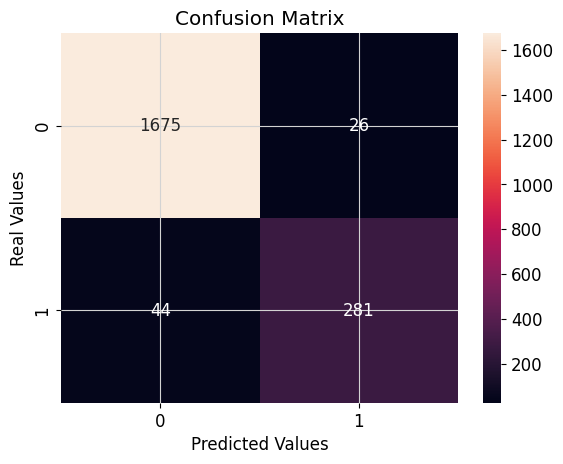

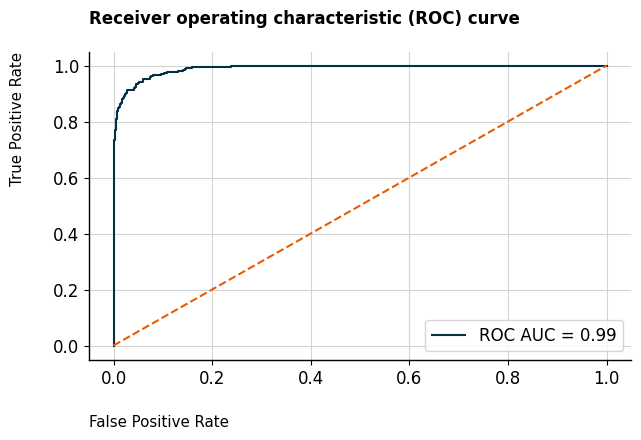

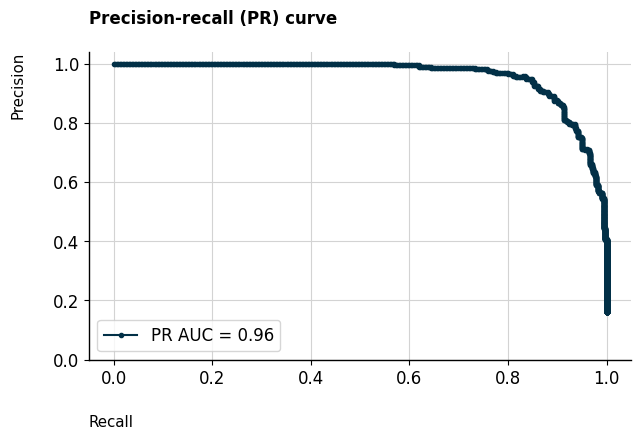

In [24]:
model_metrics = evaluate_classifier(y_test, y_pred, churn_probas)

In [25]:
model_metrics

,Metric,Value
0,Accuracy,0.965449
1,Precision,0.915309
2,Recall,0.864615
3,F1-Score,0.889241
4,ROC-AUC,0.989830
5,KS,0.890217
6,Gini,0.979661
7,PR-AUC,0.960793
8,Brier,0.028718


<b>Recall (0.86):</b> The model correctly identifies 86% of the churners. In practical terms, looking at the confusion matrix, it has accurately predicted 281 out of 325 attrited customers.<br>
<b>Precision (0.91):</b> Out of all customers predicted as churn, 91% of them are actually churners. In practical terms, considering the confusion matrix, out of 307 customers predicted as churn, 281 of them are indeed churners.<br>
<b>ROC-AUC (0.98):</b> With a ROC-AUC score of 0.98, the model demonstrates outstanding ability to differentiate between attrited and existing customers. In practive, if we randomly choose a customer that churned and a customer that dind't churn, in 98% of the time the model will estimate a higher probability of churn for that customer who actually attrited.